# Phase picker neural network

It's time to up our earthquake detection game and not only do binary classification, but add phase picking capabilities. Following the approach of the [PhaseNet](https://academic.oup.com/gji/article/216/1/261/5129142) model from 2018, improved on by Andreas K and Erik last year with the [TPhaseNet](https://academic.oup.com/gji/article/239/2/862/7740467) model, we'll be a bit clever on how we encode the target labels. 

But first, download some data. Again we use a selection of events from the STEAD dataset, but we're not too interested in pure-noise waveforms this time, so we use training and testing files containing only events with identified P and S arrival times.

In [ ]:
#! wget --no-check-certificate "https://drive.usercontent.google.com/download?id=1BEGaXFL7u8grUtK562j0AZ3YpIf2UAFL&confirm=t" -O "events_phases_Zonly_TRAIN.h5"
#! wget --no-check-certificate "https://drive.usercontent.google.com/download?id=1quRADeDu04xuYQyoSbumQo6NhOLJ3Zxb&confirm=t" -O "events_phases_Zonly_TEST.h5"

Import the usual suspects.

In [1]:
import numpy as np
import h5py
import scipy.signal
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2025-09-14 21:54:56.931613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create target labels

As shown on today's slides, a good way of framing the phase picking problem is to make the labels be a time series too, which at any given time shows whether the seismogram contains the beginning of a P arrival, the beginning of an S arrival, or no arrival at all -- the latter we'll refer to as noise. 

Ideally, our target timeseries for a recorded earthquake will then contain almost only 'noise' labels, exept for the exact microsecond of the P and S arrivals. This is a little strict, so we can allow ourselves to instead insert the arrival labels as distributions, centred around the labelled arrival time. In a couple of cells below, we'll show graphically how this works. First, let's just write the relevant code:

In [14]:
# This thing is a *generator* -- everytime it's called, it returns a new event.
class Hdf5DataGenerator:

    def __call__(self, filename, batchsize, normalise=True):

        if isinstance(filename, bytes):
            filename = filename.decode()    # Because of technical reasons

        # Open file, get datasets
        with h5py.File(filename, "r") as fin:

            waveforms = fin.get('waveforms')
            event_types = fin.get('type')
            p_start = fin.get('p_start')
            s_start = fin.get('s_start')

            waveform_length = waveforms[0].shape[0]
            istart = 0
            istop = batchsize
            exhausted = False

            # This is where we create the distribution around the pick
            pick_width = 100   # equals 1 sec
            half_pick_width = pick_width // 2
            pick = scipy.signal.windows.gaussian(pick_width, 12)

            while not exhausted:

                # Load a batch (= group) of data
                data = waveforms[istart:istop]
                targets = []

                if normalise:
                    max_vals = np.max(np.abs(data), axis=1, keepdims=True)
                    data /= (max_vals + 1e-8)

                # Create the target class waveforms 
                for i in range(len(data)):

                    p_true = np.zeros(shape=(waveform_length))    # P pick, set to [0.0, 0.0, 0.0, ...]
                    s_true = np.zeros(shape=(waveform_length))    # S pick, set to [0.0, 0.0, 0.0, ...]
                    n_true = np.ones(shape=(waveform_length))     #  Noise, set to [1.0, 1.0, 1.0, ...]

                    p_pos = p_start[istart + i]
                    s_pos = s_start[istart + i]

                    # Ensure there is a valid pick                    
                    if p_pos > half_pick_width and s_pos > half_pick_width:
                    
                        # Insert pick 
                        p_true[p_pos - half_pick_width : p_pos + half_pick_width] = pick
                        s_true[s_pos - half_pick_width : s_pos + half_pick_width] = pick
                        
                        n_true -= p_true
                        n_true -= s_true

                    targets.append(
                        np.dstack([p_true, s_true, n_true])
                    )

                # Return this batch of data (and then continue)
                yield (data, np.vstack(targets))

                istart += batchsize
                istop += batchsize

                # No more events in file.
                if istop > len(waveforms):
                    exhausted = True
                    return 

Let't try out the fancy generator thing:

batch_data.shape: (1, 6000, 1)
batch_targets.shape: (1, 6000, 3)


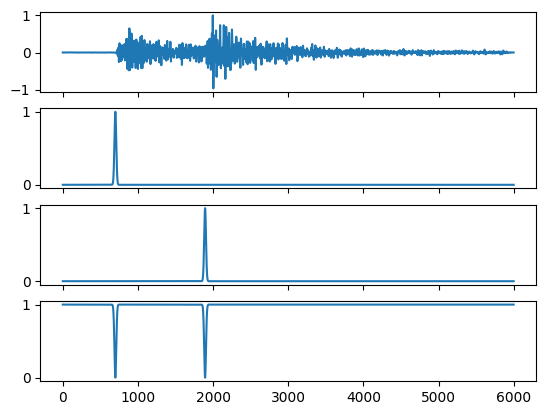

In [3]:
# Instantiate it
gen = Hdf5DataGenerator()

# Now we can loop over batches
for batch in gen('events_phases_Zonly_TRAIN.h5', 1):

    batch_data = batch[0]
    batch_targets = batch[1]
    
    print('batch_data.shape:', batch_data.shape)
    print('batch_targets.shape:', batch_targets.shape)

    # Plot the first event in the batch:
    data = batch_data[0]
    targets = batch_targets[0]

    
    _, ax = plt.subplots(4, 1, sharex=True, figsize=(12, 8)
    xvals = np.arange(data.shape[0])
    
    ax[0].plot(xvals, data[:, 0])
    ax[1].plot(xvals, targets[:, 0], color='blue')
    ax[2].plot(xvals, targets[:, 1], color='red')
    ax[3].plot(xvals, targets[:, 2], color='green')
    
    ax[0]set_ylabel('Waveform')
    ax[1]set_ylabel('P arrival')
    ax[2]set_ylabel('S arrival')
    ax[3]set_ylabel('Noise')
    

    break    # Ok let's stop it here already 

Have a look at the plot and convince yourself if this makes conceptual sense or not.

## Make a `tf.data.Dataset` (for performance)

Last time we saw that loading all data into memory at once _could_ lead to some problems, and this time around, it surely will. 

In [15]:


# make the tf dataset

filename_train = 'events_phases_Zonly_TRAIN.h5'
batch_size = 256

train_dataset = tf.data.Dataset.from_generator(
    Hdf5DataGenerator(),
    output_signature=(
        tf.TensorSpec(shape=(None, 6000, 1), dtype=tf.float32, name='data'),
        tf.TensorSpec(shape=(None, 6000, 3), dtype=tf.float32, name='targets')
    ), 
    args=(filename_train, batch_size)
)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)



data.shape: (256, 6000, 1)
target.shape: (256, 6000, 3)


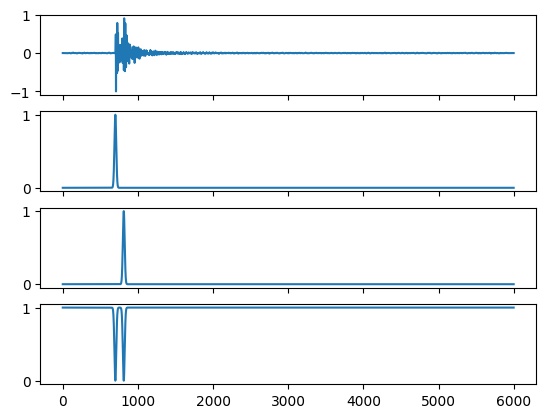

In [16]:


# test it

for i, batch in enumerate(train_dataset):

    if i == 200:

        index = 2

        data = batch[0]
        target = batch[1]
        
        print('data.shape:', data.shape)
        print('target.shape:', target.shape)

        _, ax = plt.subplots(4, 1, sharex=True)
        xvals = np.arange(data.shape[1])
    
        ax[0].plot(xvals, data[index, :, 0])
        ax[1].plot(xvals, target[index, :, 0])
        ax[2].plot(xvals, target[index, :, 1])
        ax[3].plot(xvals, target[index, :, 2])

        break



1: simple down and up

2: U-net

In [6]:
def make_model():
    
    inputs = keras.Input(shape=(6000, 1))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv1D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 64, 64]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling1D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv1D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [64, 64, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv1DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv1DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling1D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling1D(2)(previous_block_activation)
        residual = keras.layers.Conv1D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv1D(3, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)

    return model


In [19]:
model = make_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 6000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 3000, 32)  │        128 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3000, 32)  │        128 │ conv1d_37[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 3000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 3000, 32)  │          0 │ activation_15[0]… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 3000, 64)  │      6,208 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3000, 64)  │        256 │ conv1d_38[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 3000, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 3000, 64)  │     12,352 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3000, 64)  │        256 │ conv1d_39[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 1500, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 1500, 64)  │      2,112 │ activation_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 1500, 64)  │          0 │ max_pooling1d_7[… │
│                     │                   │            │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 1500, 64)  │          0 │ add_7[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 1500, 64)  │     12,352 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1500, 64)  │        256 │ conv1d_41[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 1500, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 1500, 64)  │     12,352 │ activation_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1500, 64)  │        256 │ conv1d_42[0][0] 

 Total params: 180,227 (704.01 KB)

 Trainable params: 178,499 (697.26 KB)

 Non-trainable params: 1,728 (6.75 KB)

In [20]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="categorical_crossentropy"
)

In [21]:
epochs = 10
model.fit(
    train_dataset,
    epochs=epochs,
    verbose=1,
)

model.save('phase_picker.keras')

Epoch 1/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 61s 110ms/step - loss: 0.0922
Epoch 2/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - loss: 0.0388
Epoch 3/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - loss: 0.0328
Epoch 4/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 44s 113ms/step - loss: 0.0303
Epoch 5/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 44s 114ms/step - loss: 0.0288
Epoch 6/10


2025-09-14 22:20:12.218495: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


390/390 ━━━━━━━━━━━━━━━━━━━━ 44s 113ms/step - loss: 0.0278
Epoch 7/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 44s 114ms/step - loss: 0.0268
Epoch 8/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 44s 114ms/step - loss: 0.0261
Epoch 9/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 44s 113ms/step - loss: 0.0254
Epoch 10/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - loss: 0.0248


data.shape: (1, 6000, 1)
target.shape: (1, 6000, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
preds.shape: (1, 6000, 3)


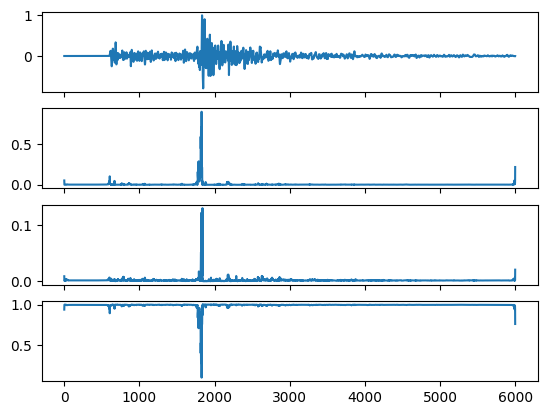

In [10]:
for batch_data, batch_target in train_dataset.take(1):
med_model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="categorical_crossentropy"
)

epochs = 5
med_model.fit(
    train_dataset,
    epochs=epochs,
    verbose=1,
)
    data = batch_data[1]
    data = np.expand_dims(data, axis=0)
    target = batch_target[1]
    target = np.expand_dims(target, axis=0)

    print('data.shape:', data.shape)
    print('target.shape:', target.shape)

    preds = model.predict(data)
    print('preds.shape:', preds.shape)

    _, ax = plt.subplots(4, 1, sharex=True)
    xvals = np.arange(data.shape[1])

    ax[0].plot(xvals, data[0, :, 0])
    ax[1].plot(xvals, preds[0, :, 0])
    ax[2].plot(xvals, preds[0, :, 1])
    ax[3].plot(xvals, preds[0, :, 2])


In [11]:

# Even simpler version with fewer layers
def create_minimal_unet_1d(input_shape=(6000, 1), num_classes=3):
    """
    Minimal 1D U-Net with just 3 levels.
    """

    inputs = keras.layers.Input(shape=input_shape)

    # Encoder
    # Level 1
    c1 = keras.layers.Conv1D(16, 9, padding='same', activation='relu')(inputs)
    c1 = keras.layers.Conv1D(16, 9, padding='same', activation='relu')(c1)
    p1 = keras.layers.MaxPooling1D(2)(c1)

    # Level 2
    c2 = keras.layers.Conv1D(32, 7, padding='same', activation='relu')(p1)
    c2 = keras.layers.Conv1D(32, 7, padding='same', activation='relu')(c2)
    p2 = keras.layers.MaxPooling1D(2)(c2)

    # Bottleneck
    c3 = keras.layers.Conv1D(64, 5, padding='same', activation='relu')(p2)
    c3 = keras.layers.Conv1D(64, 5, padding='same', activation='relu')(c3)

    # Decoder
    # Level 2
    u2 = keras.layers.UpSampling1D(2)(c3)
    u2 = keras.layers.Concatenate()([u2, c2])
    c4 = keras.layers.Conv1D(32, 7, padding='same', activation='relu')(u2)
    c4 = keras.layers.Conv1D(32, 7, padding='same', activation='relu')(c4)

    # Level 1
    u1 = keras.layers.UpSampling1D(2)(c4)
    u1 = keras.layers.Concatenate()([u1, c1])
    c5 = keras.layers.Conv1D(16, 9, padding='same', activation='relu')(u1)
    c5 = keras.layers.Conv1D(16, 9, padding='same', activation='relu')(c5)

    # Output
    outputs = keras.layers.Conv1D(num_classes, 1, activation='softmax')(c5)

    model = keras.Model(inputs=inputs, outputs=outputs, name='minimal_unet_1d')

    return model


In [17]:
med_model = create_minimal_unet_1d(input_shape=(6000, 1), num_classes=3)

med_model.summary()

Model: "minimal_unet_1d"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 6000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 6000, 16)  │        160 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 6000, 16)  │      2,320 │ conv1d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 3000, 16)  │          0 │ conv1d_27[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 3000, 32)  │      3,616 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 3000, 32)  │      7,200 │ conv1d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 1500, 32)  │          0 │ conv1d_29[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 1500, 64)  │     10,304 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 1500, 64)  │     20,544 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_10    │ (None, 3000, 64)  │          0 │ conv1d_31[0][0]   │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 3000, 96)  │          0 │ up_sampling1d_10… │
│ (Concatenate)       │                   │            │ conv1d_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 3000, 32)  │     21,536 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 3000, 32)  │      7,200 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_11    │ (None, 6000, 32)  │          0 │ conv1d_33[0][0]   │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 6000, 48)  │          0 │ up_sampling1d_11… │
│ (Concatenate)       │                   │            │ conv1d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 6000, 16)  │      6,928 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 6000, 16)  │      2,320 │ conv1d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 6000, 3)   │         51 │ conv1d_35[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 82,179 (321.01 KB)

 Trainable params: 82,179 (321.01 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
med_model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="categorical_crossentropy"
)

epochs = 5
med_model.fit(
    train_dataset,
    epochs=epochs,
    verbose=1,
)

Epoch 1/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.2377
Epoch 2/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - loss: 0.0386
Epoch 3/5


2025-09-14 22:13:49.366053: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - loss: 0.0306
Epoch 4/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - loss: 0.0288
Epoch 5/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - loss: 0.0282
